# Setup

In [1]:
import os
import ray

/Users/balajichidambaram/anaconda3/envs/docs_rag/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-25 15:48:44,294	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

In [3]:
from rag.config import ROOT_DIR
from rag.config import EMBEDDING_DIMENSIONS

In [4]:
# Credentials
ray.init(runtime_env={
    "env_vars": {
        "OPENAI_API_BASE": os.environ["OPENAI_API_BASE"],
        "OPENAI_API_KEY": os.environ["OPENAI_API_KEY"], 
        "ANYSCALE_API_BASE": os.environ["ANYSCALE_API_BASE"],
        "ANYSCALE_API_KEY": os.environ["ANYSCALE_API_KEY"],
        "DB_CONNECTION_STRING": os.environ["DB_CONNECTION_STRING"],
    },
    "working_dir": str(ROOT_DIR)
})


2024-01-25 15:48:47,101	INFO worker.py:1724 -- Started a local Ray instance.
2024-01-25 15:48:47,113	INFO packaging.py:530 -- Creating a file package for local directory '/Users/balajichidambaram/Documents/Studies/Projects/documentation_rag_llm'.
2024-01-25 15:48:47,117	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_9f67de492359573a.zip' (0.15MiB) to Ray cluster...
2024-01-25 15:48:47,118	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_9f67de492359573a.zip'.


Python version:,3.11.7
Ray version:,2.9.0


In [5]:
ray.cluster_resources()

{'memory': 2934138471.0,
 'node:__internal_head__': 1.0,
 'object_store_memory': 1467069235.0,
 'CPU': 8.0,
 'node:127.0.0.1': 1.0}

# Download Data

First, we need to download the [Ray Documentation](https://docs.ray.io/) locally.

Use this command, to download documentation to a directory

```
export EFS_DIR=/desired/directory
wget -e robots=off --recursive --no-clobber --page-requisites \
  --html-extension --convert-links --restrict-file-names=windows \
  --domains docs.ray.io --no-parent --accept=html \
  -P $EFS_DIR https://docs.ray.io/en/master/
```

In [6]:
# Download Dataset
# !export EFS_DIR=/Users/balajichidambaram/Documents/Studies/Projects/documentation_rag_llm/data
# !wget -e robots=off --recursive --no-clobber --page-requisites \
#   --html-extension --convert-links --restrict-file-names=windows \
#   --domains docs.ray.io --no-parent --accept=html \
#   -P $EFS_DIR https://docs.ray.io/en/master/

# Load Data

In [7]:
from pathlib import Path
from rag.config import EFS_DIR


Now, we need to convert our data into a Ray Dataset.

In [8]:
DOCS_DIR = Path(EFS_DIR, "docs.ray.io/en/master/")
ds = ray.data.from_items([{"path": path} for path in DOCS_DIR.rglob("*.html") if not path.is_dir()])
print(f"{ds.count()} documents")

2024-01-25 15:48:48,088	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


3053 documents


# Sections

Now that we have a dataset of all the paths to the html files, we are going to develop a functions that can extract content from the html files. We want to do this extraction in a generalized manner so that the extraction can be performed across all of the documentation. The process is to identify all the sections in the html page and extract the text in each section. We save all the extracted data into a list of dictionaries that map the text within a section to a specific url within a section anchor id. 

In [9]:
from rag.data import extract_sections

In [10]:
sample_html_fp = Path(EFS_DIR, "docs.ray.io/en/master/ray-core/key-concepts.html")
extract_sections({"path": sample_html_fp})[1]

{'source': 'https://docs.ray.io/en/master/ray-core/key-concepts.html#tasks',
 'text': '\nTasks#\nRay enables arbitrary functions to be executed asynchronously on separate Python workers. These asynchronous Ray functions are called “tasks”. Ray enables tasks to specify their resource requirements in terms of CPUs, GPUs, and custom resources. These resource requests are used by the cluster scheduler to distribute tasks across the cluster for parallelized execution.\nSee the User Guide for Tasks.'}

In [11]:
#Extract sections for all paths in ray dataset
section_ds = ds.flat_map(extract_sections)
section_ds.count()

2024-01-25 15:48:49,142	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)]
2024-01-25 15:48:49,142	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-01-25 15:48:49,143	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


(FlatMap(extract_sections) pid=25027) /Users/balajichidambaram/anaconda3/envs/docs_rag/lib/python3.11/site-packages/ray/data/_internal/pandas_block.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
(FlatMap(extract_sections) pid=25027)   if isinstance(items[0], TensorArrayElement):                      
(FlatMap(extract_sections) pid=25027) /Users/balajichidambaram/anaconda3/envs/docs_rag/lib/python3.11/site-packages/ray/data/_internal/pandas_block.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
(FlatMap(extract_sections) pid=25027)   return items[0]                                                   
(FlatMap(ext

5600

In [12]:
section_lengths = []
for section in section_ds.take_all():
    section_lengths.append(len(section["text"]))

2024-01-25 15:49:23,404	WARNING plan.py:588 -- Warning: The Ray cluster currently does not have any available CPUs. The Dataset job will hang unless more CPUs are freed up. A common reason is that cluster resources are used by Actors or Tune trials; see the following link for more details: https://docs.ray.io/en/latest/data/data-internals.html#ray-data-and-tune


# Chunk Data

Now that we have list of sections (each with a section uri and the text), but we cannot pass this directly to a RAG application just yet. Because we each section may have varying length of context and many are quite large chunk.

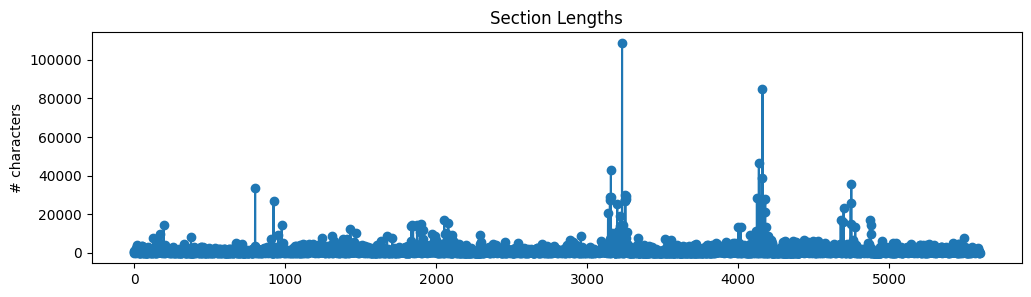

In [13]:
import matplotlib.pyplot as plt

#Plot
plt.figure(figsize=(12,3))
plt.plot(section_lengths, marker='o')
plt.title("Section Lengths")
plt.ylabel("# characters")
plt.show()

If we use these large sections, we would be introducing noisy/unwanted context to RAG application and because LLMs have a maximun context length as a limitation, we would not be able fit too much other relevant context. To overcome, we are going to split the text within each section into smaller chunks of data. Intuitively, we want that with each chunk of data encapsulating a single/few concepts and will be less noisy compared to large chunks of data. The chunk size, typically is going to be typical text splitting values(eg. chunk_size=300). We can experiment with different chunk sizes as well.

In [14]:
from  functools import partial
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [15]:
# Text splitter

chunk_size = 300
chunk_overlap = 50

text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n","\n", " ", ""],
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len
)

In [16]:
#Chunk a sample section
sample_section = section_ds.take(1)[0]
chunks = text_splitter.create_documents(
    texts=[sample_section["text"]], 
    metadatas=[{"source": sample_section["source"]}])
print (chunks[0])

2024-01-25 15:49:24,024	INFO dataset.py:2488 -- Tip: Use `take_batch()` instead of `take() / show()` to return records in pandas or numpy batch format.
2024-01-25 15:49:24,049	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)] -> LimitOperator[limit=1]
2024-01-25 15:49:24,050	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-01-25 15:49:24,051	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
(FlatMap(extract_sections) pid=25027) /Users/balajichidambaram/anaconda3/envs/docs_rag/lib/python3.11/site-packages/ray/data/_internal/pandas_blo

page_content='ray.job_submission.JobType.partition#\nJobType.partition(sep, /)#\nPartition the string into three parts using the given separator.\nThis will search for the separator in the string.  If the separator is found,\nreturns a 3-tuple containing the part before the separator, the separator' metadata={'source': 'https://docs.ray.io/en/master/cluster/running-applications/job-submission/doc/ray.job_submission.JobType.partition.html#ray-job-submission-jobtype-partition'}


While chunking is relatively fast, let's wrap the chunking logic in a function so that we can apply the workload at scale. This ensure that chunking remains fast as our data grows.

In [17]:
def chunk_section(section, chunk_size, chunk_overlap):
    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len
    )
    chunks = text_splitter.create_documents(
        texts=[section["text"]],
        metadatas=[{"source": section["source"]}]
    )
    return [{"text": chunk.page_content, "source": chunk.metadata["source"]} for chunk in chunks]

In [18]:
# Scale chunking
chunk_ds = section_ds.flat_map(partial(
    chunk_section,
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap
))

print(f"{chunk_ds.count()} chunks")
chunk_ds.show(1)

2024-01-25 15:49:25,408	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial)]
2024-01-25 15:49:25,408	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-01-25 15:49:25,409	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
Running: 0.0/8.0 CPU, 0.0/0.0 GPU, 0.0 MiB/349.78 MiB object_store_memory:   0%|          | 0/200 [00:00<?, ?it/s]

(FlatMap(extract_sections)->FlatMap(partial) pid=25027) /Users/balajichidambaram/anaconda3/envs/docs_rag/lib/python3.11/site-packages/ray/data/_internal/pandas_block.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
(FlatMap(extract_sections)->FlatMap(partial) pid=25027)   if isinstance(items[0], TensorArrayElement):    
(FlatMap(extract_sections)->FlatMap(partial) pid=25027) /Users/balajichidambaram/anaconda3/envs/docs_rag/lib/python3.11/site-packages/ray/data/_internal/pandas_block.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
(FlatMap(extract_sections)->FlatMap(partial) pid=25027)   return items[0]          

30362 chunks


(FlatMap(extract_sections)->FlatMap(partial) pid=25027) /Users/balajichidambaram/anaconda3/envs/docs_rag/lib/python3.11/site-packages/ray/data/_internal/pandas_block.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]` [repeated 932x across cluster]
(FlatMap(extract_sections)->FlatMap(partial) pid=25027)   if isinstance(items[0], TensorArrayElement): [repeated 466x across cluster]
(FlatMap(extract_sections)->FlatMap(partial) pid=25027)   return items[0] [repeated 466x across cluster]
                                                                                                                         

{'text': 'Quickstart using the Ray Jobs CLI#\nThis guide walks through the Ray Jobs CLI commands available for submitting and interacting with a Ray Job.\nTo use the Jobs API programmatically with a Python SDK instead of a CLI, see Python SDK Overview.', 'source': 'https://docs.ray.io/en/master/cluster/running-applications/job-submission/quickstart.html#quickstart-using-the-ray-jobs-cli'}


# Embed Data

Now that we have created small chunks of data, we need a way to identify most relevant chunks for a given query. A quick way is to embed our data using a pretrained model and use the same model to embed the query. Once the embeddings for the chunks and query are generated, we can calculated the distance between all the chunk embeddings and query embedding to determine the top-k chunks. There are multiple pre-trained models that are pre-trained on a very large corpus of text through tasks such as next/masked token prediction which allowed them to learn to represent subtokens in N dimensions and capture semantic relationships. We can use these models to identify relevant contexts for our query.

**Note**

Embeddings are not the only way to decide relevant contexts. We could use a LLM to decide but generally this option is expensive and slower since LLMs are siginficantly larger than embedding models and have context length limitation. But we can retrieve the top-k chunks to embedding models and then use these top chunks as context to answer our query by passing it to an LLM.

In [19]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
import numpy as np
from ray.data import ActorPoolStrategy

(FlatMap(extract_sections)->FlatMap(partial) pid=25028) /Users/balajichidambaram/anaconda3/envs/docs_rag/lib/python3.11/site-packages/ray/data/_internal/pandas_block.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
(FlatMap(extract_sections)->FlatMap(partial) pid=25028)   if isinstance(items[0], TensorArrayElement):
(FlatMap(extract_sections)->FlatMap(partial) pid=25028) /Users/balajichidambaram/anaconda3/envs/docs_rag/lib/python3.11/site-packages/ray/data/_internal/pandas_block.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
(FlatMap(extract_sections)->FlatMap(partial) pid=25028)   return items[0]


In [20]:
def get_embedding_model(embedding_model_name, model_kwargs, encode_kwargs):
    if embedding_model_name == "text-embedding-ada-002":
        embedding_model = OpenAIEmbeddings(
            model=embedding_model_name,
            openai_api_base=os.environ["OPENAI_API_BASE"],
            openai_api_key=os.environ["OPENAI_API_KEY"])
    else:
        embedding_model = HuggingFaceEmbeddings(
            model_name=embedding_model_name,  # also works with model_path
            model_kwargs=model_kwargs,
            encode_kwargs=encode_kwargs)
    return embedding_model

In [21]:
class EmbedChunks:
    def __init__(self, model_name) -> None:
        self.embedding_model = get_embedding_model(
            model_name,
            model_kwargs={"device":"cpu"},
            encode_kwargs={"device": "cpu", "batch_size": 100}
        )
    def __call__(self, batch):
        embeddings = self.embedding_model.embed_documents(batch["text"])
        return {"text": batch["text"], "source": batch["source"], "embeddings": embeddings}

Now we are able to embed chunks at scale using `map_batches()`. All we have to do is define the `batch_size` and the compute resources.

In [22]:
embedding_model_name = "thenlper/gte-base"
embedded_chunks = chunk_ds.map_batches(
    EmbedChunks,
    fn_constructor_kwargs={"model_name": embedding_model_name},
    batch_size=100,
    concurrency=2
)

In [23]:
# Sample
# sample = embedded_chunks.take(1)
# print ("embedding size:", len(sample[0]["embeddings"]))
# print (sample[0]["text"])

# Index Data


Now that we have embedded chunks, we have to index them and store them so that we can quickly retrieve them for inference. To store the embedded chunks, we are using pgvector. We'll create a table (document) and write the (text, source, embedding) triplets for each embedded chunk we have.

In [31]:
import psycopg
from pgvector.psycopg import register_vector
os.environ["MIGRATION_FP"] = f"../migrations/vector-{EMBEDDING_DIMENSIONS[embedding_model_name]}.sql"
os.environ["SQL_DUMP_FP"] = f"{EFS_DIR}/sql_dumps/{embedding_model_name.split('/')[-1]}_{chunk_size}_{chunk_overlap}.sql"
os.environ["PATH"] = os.environ["PATH"] + ":/Applications/Postgres.app/Contents/Versions/latest/bin"


In [25]:
print(os.environ["MIGRATION_FP"], os.environ["SQL_DUMP_FP"])

../migrations/vector-768.sql /Users/balajichidambaram/Documents/Studies/Projects/documentation_rag_llm/data/sql_dumps/gte-base_300_50.sql"


In [26]:
%%bash
# Set up
psql "$DB_CONNECTION_STRING" -c "DROP TABLE IF EXISTS document;"
echo $MIGRATION_FP
psql "$DB_CONNECTION_STRING" -f $MIGRATION_FP
echo $SQL_DUMP_FP


DROP TABLE
../migrations/vector-768.sql
CREATE TABLE
/Users/balajichidambaram/Documents/Studies/Projects/documentation_rag_llm/data/sql_dumps/gte-base_300_50.sql"


If we don't have an index saved already, we can index the data and save it. And once again, we can use Ray Data’s map_batches to perform this indexing in parallel:

In [27]:
class StoreResults:
    def __call__(self, batch):
        with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
            register_vector(conn)
            with conn.cursor() as cur:
                for text, source, embedding in zip(batch["text"], batch["source"], batch["embeddings"]):
                    cur.execute("INSERT INTO document (text, source, embedding) VALUES (%s, %s, %s)", (text, source, embedding,),)
        return {}

In [28]:
# Index data
embedded_chunks.map_batches(
    StoreResults,
    batch_size=128,
    concurrency=2,
).count()

2024-01-25 15:50:01,730	INFO streaming_executor.py:112 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[FlatMap(extract_sections)->FlatMap(partial)->MapBatches(EmbedChunks)] -> ActorPoolMapOperator[MapBatches(StoreResults)]
2024-01-25 15:50:01,731	INFO streaming_executor.py:113 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), exclude_resources=ExecutionResources(cpu=0, gpu=0, object_store_memory=0), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2024-01-25 15:50:01,731	INFO streaming_executor.py:115 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


2024-01-25 15:50:01,748	INFO actor_pool_map_operator.py:114 -- FlatMap(extract_sections)->FlatMap(partial)->MapBatches(EmbedChunks): Waiting for 4 pool actors to start...
2024-01-25 15:50:08,196	INFO actor_pool_map_operator.py:114 -- MapBatches(StoreResults): Waiting for 4 pool actors to start...
(MapWorker(FlatMap(extract_sections)->FlatMap(partial)->MapBatches(EmbedChunks)) pid=25045) /Users/balajichidambaram/anaconda3/envs/docs_rag/lib/python3.11/site-packages/ray/data/_internal/pandas_block.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
(MapWorker(FlatMap(extract_sections)->FlatMap(partial)->MapBatches(EmbedChunks)) pid=25045)   if isinstance(items[0], TensorArrayElement):
(MapWorker(FlatMap(extract_sections)->FlatMap(partial)->MapBatches(EmbedChunks)) pid=25045) /Users/balajichidambaram/anaco

0

In [34]:
%%bash
# Save index
rm -rf $SQL_DUMP_FP
mkdir -p $(dirname "$SQL_DUMP_FP") && touch $SQL_DUMP_FP
pg_dump "$DB_CONNECTION_STRING" -c > $SQL_DUMP_FP  # save